In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from enum import Enum

Let's have a look at the tensorflow implementation for very large batchsizes - to see just how much performance we can squeeze out.

Note a lot of this work is simply repeated from the `main.ipynb` notebook - nothing too exciting here! For detailed descriptions / discussions of methods, read over that notebook first. We are just focussing on large batchsized tensorflow here.

In [7]:
DATA_FILE = "../Implementations/python_tensorflow/rand_gpu_data_large.csv"
df = pd.read_csv(DATA_FILE)
df["time"] /= 1E9
df["effective_multiplications"] = df["trials"] * df["multiplications"]
display(df)

,trials,multiplications,batchsize,time,effective_multiplications
0,37020,19302,32768,47.956416,714560040
1,22741,10710,16384,14.932467,243556110
2,21596,28189,4096,43.631306,608769644
3,35112,7462,8192,20.549950,262005744
4,10652,26989,4096,18.640961,287486828
...,...,...,...,...,...
1058,14445,7170,8192,6.624791,103570650
1059,64820,20564,32768,50.903952,1332958480
1060,22787,4880,2048,10.362415,111200560
1061,38573,13822,32768,34.924144,533156006


It should be noted that the bug where `trials < batchsize` was fixed on the script side, meaning we do not have to filter our data here.

Let's start by just plotting the data split by batchsizes, to ensure everything is still linear:

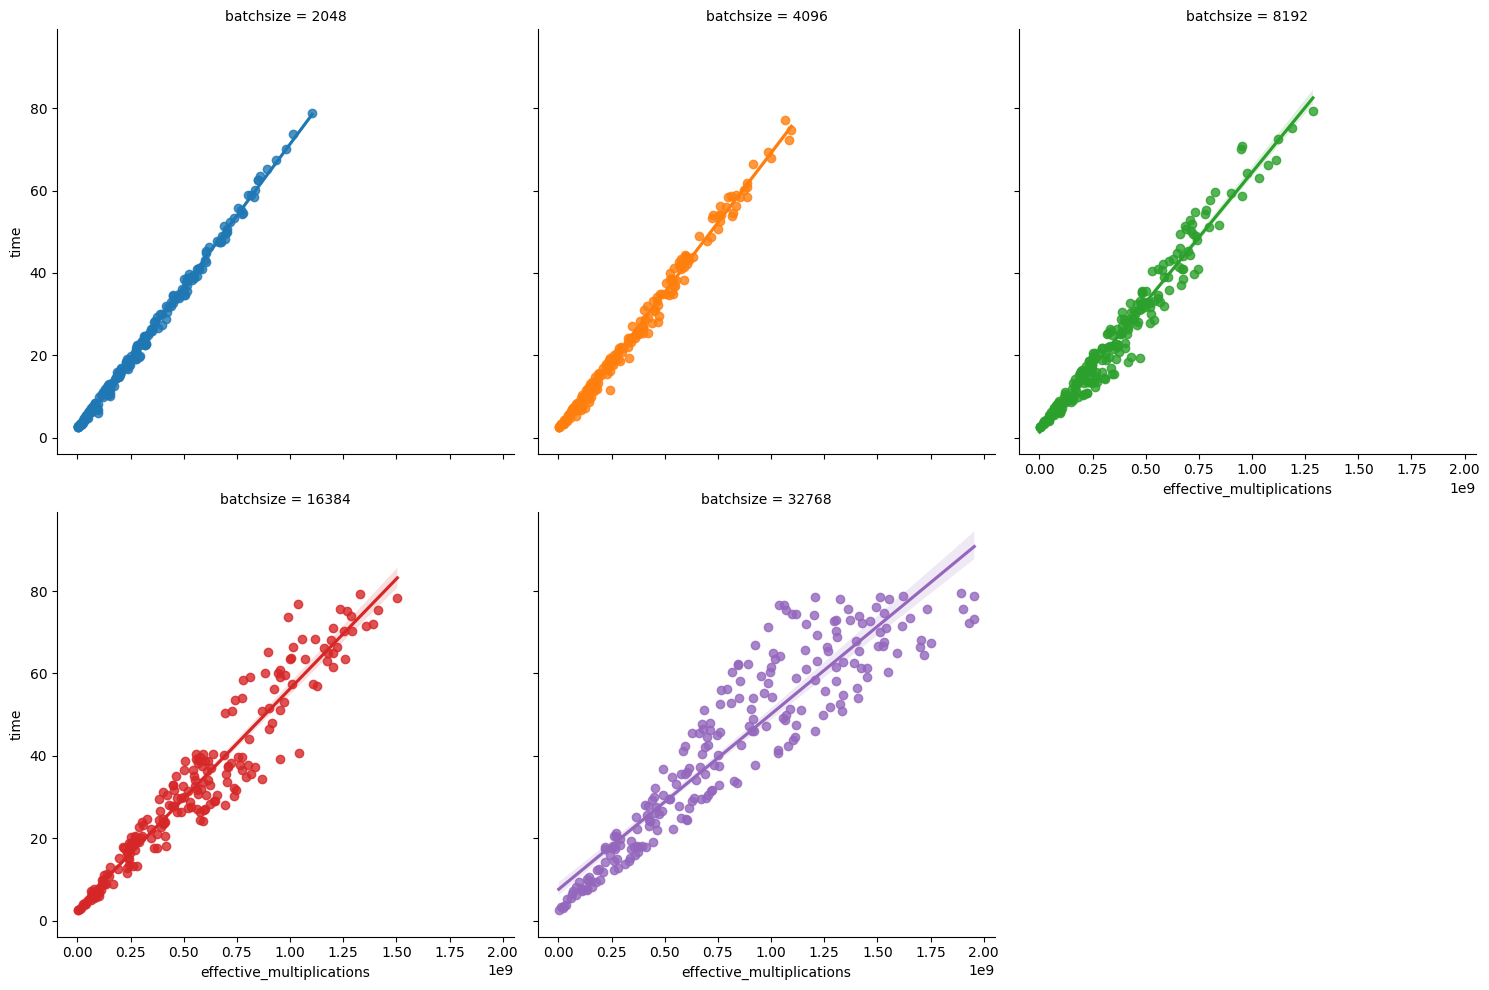

In [14]:
facet_grid = sns.lmplot(data=df, x="effective_multiplications", y="time", col="batchsize", hue="batchsize", col_wrap=3)

Interesting! It appears that with growing batchsize we get larger spread in the data, as well as a seemingly larger intercept. This could be due to having to shift more data onto the GPU before multiplications can begin.

,batchsize,slope,intercept,r squared
0,2048,6.940848e-08,1.898434,0.997194
1,4096,6.756110e-08,1.572271,0.991914
2,8192,6.312819e-08,1.299702,0.963922
3,16384,5.331532e-08,2.983952,0.924595
4,32768,4.257572e-08,7.548843,0.857021


Text(0, 0.5, 'Slope of Linear Regression')

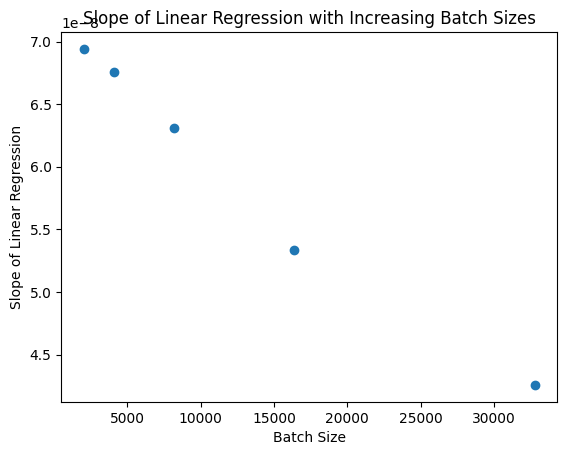

In [60]:
from sklearn.linear_model import LinearRegression

regression_df = pd.DataFrame()
batchsizes = df["batchsize"].unique()
batchsizes.sort()
for batchsize in batchsizes:
    target_data = df.loc[df["batchsize"]==batchsize]
    X = target_data["effective_multiplications"].astype(float).values.reshape(-1,1)
    y = target_data["time"].values.reshape(-1,1)
    regression = LinearRegression().fit(X,y)

    slope = regression.coef_[0,0]
    intercept = regression.intercept_[0]
    R2 = regression.score(X,y)
    curr_regr = pd.DataFrame([[batchsize, slope, intercept, R2]], columns=["batchsize", "slope", "intercept", "r squared"])
    regression_df = pd.concat([regression_df, curr_regr], ignore_index=True)
display(regression_df)

plt.scatter(regression_df["batchsize"], regression_df["slope"])
plt.title("Slope of Linear Regression with Increasing Batch Sizes")
plt.xlabel("Batch Size")
plt.ylabel("Slope of Linear Regression")

Having a look at our linear regression we again see that increasing batchsizes decreases the slope of our linear regression - it takes less time to perform the multiplications. This isn't a massive shock - but it is interesting that this trend is still rather linear! Perhaps we can squeeze EVEN MORE performance from the GPU...

We also now have concrete numbers to state the spread is increasing with batchsize - just observe the diminishing R^2 value!

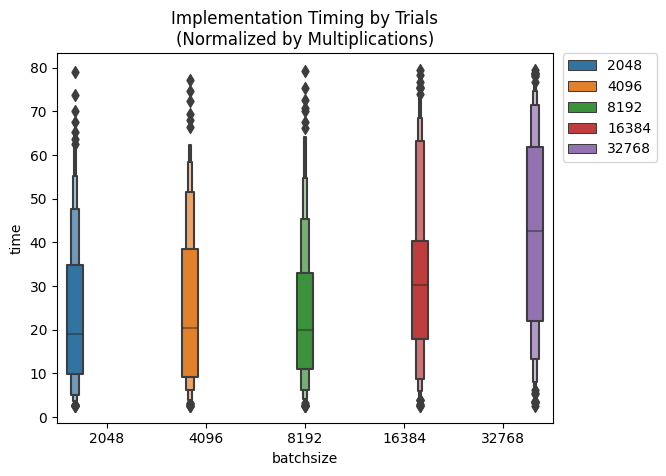

In [58]:
target_data = df.copy()
target_data["time"] /= target_data["multiplications"]

sns.boxenplot(data=df, y="time", x="batchsize", hue="batchsize", showfliers=True)\
    .set(title="Implementation Timing by Trials\n(Normalized by Multiplications)")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.show()

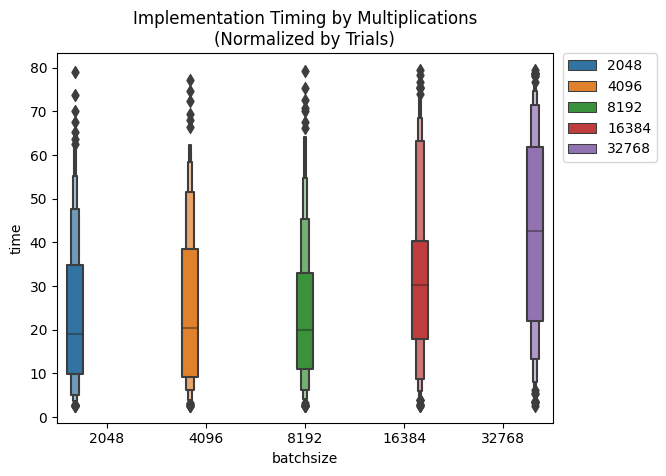

In [57]:
target_data = df.copy()
target_data["time"] /= target_data["trials"]

sns.boxenplot(data=df, y="time", x="batchsize", hue="batchsize", showfliers=True)\
    .set(title="Implementation Timing by Multiplications\n(Normalized by Trials)")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.show()